## Property Fraud Identification
**Yao Wan**

#### Data Cleaning and Feature Building

In [1]:
# Import packages and read in the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline
data = pd.read_csv("NY property data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070994 entries, 0 to 1070993
Data columns (total 32 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   RECORD    1070994 non-null  int64  
 1   BBLE      1070994 non-null  object 
 2   B         1070994 non-null  int64  
 3   BLOCK     1070994 non-null  int64  
 4   LOT       1070994 non-null  int64  
 5   EASEMENT  4636 non-null     object 
 6   OWNER     1039249 non-null  object 
 7   BLDGCL    1070994 non-null  object 
 8   TAXCLASS  1070994 non-null  object 
 9   LTFRONT   1070994 non-null  int64  
 10  LTDEPTH   1070994 non-null  int64  
 11  EXT       354305 non-null   object 
 12  STORIES   1014730 non-null  float64
 13  FULLVAL   1070994 non-null  float64
 14  AVLAND    1070994 non-null  float64
 15  AVTOT     1070994 non-null  float64
 16  EXLAND    1070994 non-null  float64
 17  EXTOT     1070994 non-null  float64
 18  EXCD1     638488 non-null   float64
 19  STADDR    1070318 non

##### 1. Remove properties owned by city, state or federal governments


In [2]:
# Create list of owners to be removed
remove_list = ['PARKCHESTER PRESERVAT', 'PARKS AND RECREATION', 'DCAS',
'HOUSING PRESERVATION', 'CITY OF NEW YORK', 'DEPT OF ENVIRONMENTAL',
'BOARD OF EDUCATION', 'NEW YORK CITY HOUSING', 'CNY/NYCTA',
'NYC HOUSING PARTNERSH', 'DEPARTMENT OF BUSINES', 'DEPT OF TRANSPORTATIO',
'MTA/LIRR', 'PARCKHESTER PRESERVAT', 'MH RESIDENTIAL 1, LLC', 'LINCOLN PLAZA ASSOCIA',
'UNITED STATES OF AMER', 'U S GOVERNMENT OWNRD', 'THE CITY OF NEW YORK', 
'NYS URBAN DEVELOPMENT', 'NYS DEPT OF ENVIRONME', 'CULTURAL AFFAIRS', 
'DEPT OF GENERAL SERVI', 'DEPT RE-CITY OF NY']

property_data = data[~data['OWNER'].isin(remove_list)].reset_index(drop=True)


##### 2. Fill in the missing ZIPs

In [3]:
# Missing zip code indeces
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)


21772

In [4]:
# If the zip on both the record before and after the record with the missing zip are the same, replace by that zip code

for i in range(len(missing_zips)):
    if property_data.loc[missing_zips[i]+1,'ZIP']==property_data.loc[missing_zips[i]-1,'ZIP']:
        property_data.loc[missing_zips[i],'ZIP']= property_data.loc[missing_zips[i]-1,'ZIP']

missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

10245

In [5]:
# Replace all the missing zips with the zip from the record above it

for i in range(len(missing_zips)):
    property_data.loc[missing_zips[i],'ZIP']= property_data.loc[missing_zips[i]-1,'ZIP']

missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

0

##### 3. Fill in missing FULLVAL, AVLAND, AVTOT


In [6]:
# Calculate mean for FULLVAL

property_data['FULLVAL'].replace('NaN', 0)
temp = property_data[property_data['FULLVAL']!=0]
mean_fullval = temp.groupby('TAXCLASS')['FULLVAL'].mean()
print(mean_fullval)

TAXCLASS
1     5.700059e+05
1A    3.352942e+05
1B    3.738399e+05
1C    7.615359e+05
1D    2.233614e+07
2     8.005832e+05
2A    8.639066e+05
2B    1.254525e+06
2C    7.723493e+05
3     8.510005e+04
4     2.772747e+06
Name: FULLVAL, dtype: float64


In [7]:
# Calculate mean for AVLAND
property_data['AVLAND'].replace('NaN', 0)
temp_avland = property_data[property_data['AVLAND']!=0]
mean_avland = temp_avland.groupby('TAXCLASS')['AVLAND'].mean()

In [8]:
# Calculate mean for AVTOT
property_data['AVTOT'].replace('NaN', 0)
temp_avtot = property_data[property_data['AVTOT']!=0]
mean_avtot = temp_avtot.groupby('TAXCLASS')['AVTOT'].mean()

In [9]:
# Print the mean_fullval table
mean_fullval

TAXCLASS
1     5.700059e+05
1A    3.352942e+05
1B    3.738399e+05
1C    7.615359e+05
1D    2.233614e+07
2     8.005832e+05
2A    8.639066e+05
2B    1.254525e+06
2C    7.723493e+05
3     8.510005e+04
4     2.772747e+06
Name: FULLVAL, dtype: float64

In [10]:
# Substituting missing values with means
for index in mean_fullval.index:
    property_data.loc[(property_data['FULLVAL']==0)&(property_data['TAXCLASS']==index),'FULLVAL']=mean_fullval[index]
    property_data.loc[(property_data['AVLAND']==0)&(property_data['TAXCLASS']==index),'AVLAND']=mean_avland[index]
    property_data.loc[(property_data['AVTOT']==0)&(property_data['TAXCLASS']==index),'AVTOT']=mean_avtot[index]


##### 4. Fill in missing STORIES


In [11]:
# Check the number of null values in STORIES
temp = property_data[property_data['STORIES'].isnull()]
len(temp)

43968

In [12]:
# Check the number of null values of STORIES in each TAXCLASS
temp['TAXCLASS'].value_counts()

1B    19055
4     17979
2      3434
3      2416
1       877
2C      138
2B       34
2A       30
1A        5
Name: TAXCLASS, dtype: int64

In [13]:
# Calculate the means of STORIES grouped by TAXCLASS
mean_stories = property_data.groupby('TAXCLASS')['STORIES'].mean()
print(mean_stories)

TAXCLASS
1      2.111633
1A     1.656867
1B     4.000000
1C     3.052748
1D     1.068966
2     16.310549
2A     2.844032
2B     4.001635
2C     4.744977
3      1.000000
4      5.517257
Name: STORIES, dtype: float64


In [14]:
# Check if there is no 0 value in STORIES
len(property_data[property_data['STORIES']==0])

0

In [15]:
# Replace null by 0 and fill them with the averages calculated
property_data['STORIES']=property_data['STORIES'].fillna(value=0)
for index in mean_stories.index:
    property_data.loc[(property_data['STORIES']==0)&(property_data['TAXCLASS']==index),'STORIES']=mean_stories[index]
property_data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
B,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,P7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,0,0,0


##### 5. Fill in LTFRONT, LTDEPTH, BLDFRONT, BLDDEPTH


In [16]:
# Replace the 0’s and 1’s by NAs so they are not counted in calculating mean
property_data.loc[property_data['LTFRONT']==0,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==0,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==0,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==0,'BLDDEPTH']=np.nan
property_data.loc[property_data['LTFRONT']==1,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==1,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==1,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==1,'BLDDEPTH']=np.nan

In [17]:
# Calculate the mean
mean_LTFRONT=property_data.groupby(property_data['TAXCLASS'])['LTFRONT'].mean()
mean_LTDEPTH=property_data.groupby(property_data['TAXCLASS'])['LTDEPTH'].mean()
mean_BLDFRONT=property_data.groupby(property_data['TAXCLASS'])['BLDFRONT'].mean()
mean_BLDDEPTH=property_data.groupby(property_data['TAXCLASS'])['BLDDEPTH'].mean()

In [18]:
# Impute values
for index in mean_LTFRONT.index:
    property_data.loc[(property_data['LTFRONT'].isnull())&(property_data['TAXCLASS']==index),'LTFRONT']=mean_LTFRONT[index]    
    property_data.loc[(property_data['LTDEPTH'].isnull())&(property_data['TAXCLASS']==index),'LTDEPTH']=mean_LTDEPTH[index]
    property_data.loc[(property_data['BLDFRONT'].isnull())&(property_data['TAXCLASS']==index),'BLDFRONT']=mean_BLDFRONT[index]
    property_data.loc[(property_data['BLDDEPTH'].isnull())&(property_data['TAXCLASS']==index),'BLDDEPTH']=mean_BLDDEPTH[index]

#### Calculate Fraud Algorithm Variables (HW2)

##### 1. Create 3 sizes: LOTAREA, BLDAREA, BLDVOL

In [19]:
property_data['LOTAREA'] = property_data['LTFRONT'] * property_data['LTDEPTH']
property_data['BLDAREA'] = property_data['BLDFRONT'] * property_data['BLDDEPTH']
property_data['BLDVOL'] = property_data['BLDAREA'] * property_data['STORIES']

##### 2. Create 9 variables, r1 to r9

In [20]:
variables = pd.DataFrame(property_data['RECORD'])
count = 0
# loop through all value fields
for i in ['FULLVAL','AVLAND','AVTOT']:
    # loop through all size fields
    for j in ['LOTAREA','BLDAREA','BLDVOL']:
        count +=1
        # create variable r* by dividing each value field by each size
        variables['r'+str(count)] = property_data[i]/property_data[j]

##### 3. Create variables r1_zip5 ... r9_boro

In [21]:
# create zip3 variable by extracting the first 3 digits of ZIP
property_data['zip3'] = [property_data.loc[i, 'ZIP'].astype(str)[:3] for i in range(len(property_data))]

In [22]:
# Create dictionary for variable name transformations
var_name = {'ZIP':'zip5','zip3':'zip3','TAXCLASS':'taxclass','B':'boro'}
# Loop through all 4 scale factors
for j in var_name.keys():
    # Loop through all 9 "r" variables
    for i in ['r'+str(i) for i in range(1,10)]:
        # Calculate the average for each "r" variable grouped by each scale factor
        avg = variables.groupby(property_data[j])[i].transform(np.mean)
        # Create new variable by dividing existing "r" variable by its grouped averages
        variables[i+'_'+var_name[j]] = variables[i]/avg
        

In [23]:
# Merge the dataframe "variables" to the original dataframe for reference
# property_data = property_data.merge(variables, on='RECORD')

In [24]:
property_data

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,LOTAREA,BLDAREA,BLDVOL,zip3
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500.000000,...,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,523000.000000,5357.483793,29558.615789,100
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27.000000,...,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,3359.981897,5357.483793,29558.615789,100
2,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,82.296384,...,NaN,NaN,NaN,FINAL,2010/11,AC-TR,10241.272557,5357.483793,267874.189672,100
3,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,82.296384,...,NaN,NaN,NaN,FINAL,2010/11,AC-TR,10241.272557,5357.483793,267874.189672,100
4,11,1000041003,1,4,1003,NaN,"TRZ HOLDINGS, LLC",R5,4,82.296384,...,NaN,NaN,NaN,FINAL,2010/11,AC-TR,10241.272557,5357.483793,267874.189672,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046821,1070990,5080500083,5,8050,83,NaN,"TOBIN, GALE",A1,1,60.000000,...,NaN,NaN,NaN,FINAL,2010/11,AC-TR,7200.000000,780.000000,1950.000000,103
1046822,1070991,5080500086,5,8050,86,NaN,SHERRI MILINAZZO,A1,1,62.000000,...,NaN,NaN,NaN,FINAL,2010/11,AC-TR,14136.000000,832.000000,2080.000000,103
1046823,1070992,5080500089,5,8050,89,NaN,JOHN GERVASI,A1,1,53.000000,...,NaN,NaN,1017.0,FINAL,2010/11,AC-TR,14469.000000,768.000000,1536.000000,103
1046824,1070993,5080500092,5,8050,92,NaN,RITA M MOOG,A1,1,52.000000,...,NaN,NaN,NaN,FINAL,2010/11,AC-TR,7072.000000,672.000000,1344.000000,103


In [25]:
# Getting the stats of varialbes
stats = variables.describe().transpose()
stats = stats.drop('RECORD')
# Rounding everything except min
min = stats['min']
stats = stats.round(2)
stats['min'] = min
stats['count'] = stats['count'].astype(int)
# Save result
# stats.to_csv('stats_on_vars.csv')
stats

,count,mean,std,min,25%,50%,75%,max
r1,1046826,213.57,532.56,3.905765e-04,76.26,152.86,243.18,138637.34
r2,1046826,536.42,1027.44,7.466192e-04,211.82,500.00,683.82,310551.57
r3,1046826,244.08,498.82,8.983394e-05,82.50,239.06,336.23,227500.00
r4,1046826,10.46,69.98,8.333333e-06,2.35,4.60,7.23,22249.80
r5,1046826,22.82,378.51,2.096125e-04,6.20,14.98,20.29,334636.37
r6,1046826,10.04,178.33,1.038033e-05,2.02,7.15,10.04,111545.46
r7,1046826,26.83,203.87,8.333333e-06,5.28,8.58,13.53,64711.85
r8,1046826,50.46,932.20,3.062474e-04,17.47,26.98,36.00,871362.22
r9,1046826,19.07,327.02,6.049251e-05,7.09,12.68,17.58,290454.07
r1_zip5,1046826,1.00,2.16,2.228349e-06,0.46,0.92,1.23,747.76


In [26]:
variables

,RECORD,r1,r2,r3,r4,r5,r6,r7,r8,r9,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,1,40.917782,3994.412456,723.985188,8.079350,788.709805,142.953243,18.413002,1797.485605,325.793334,...,4.715588,0.113902,7.712077,6.469193,0.241395,16.606462,13.685555,0.198288,14.042014,14.957255
1,2,57678.882190,36173.697854,6556.463990,4258.951518,2671.030012,484.122805,25955.496986,16278.164034,2950.408795,...,42.704717,160.560217,69.841147,58.585497,127.249178,56.239136,46.347248,279.513149,127.165526,135.454020
2,9,385.182796,736.308714,14.726174,62.110738,118.729804,2.374596,173.332268,331.338940,6.626779,...,0.095917,1.072230,1.421603,0.131586,1.855748,2.499883,0.227331,1.866605,2.588430,0.304237
3,10,556.662267,1064.105879,21.282118,89.761892,171.587267,3.431745,250.498069,478.847739,9.576955,...,0.138618,1.549576,2.054487,0.190167,2.681911,3.612808,0.328536,2.697598,3.740773,0.439680
4,11,1035.027624,1978.540749,39.570815,94.470682,180.588507,3.611770,465.762431,890.343337,17.806867,...,0.257740,2.881198,3.820001,0.353586,2.822600,3.802332,0.345771,5.015767,6.955390,0.817518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046821,1070990,60.833333,561.538462,224.615385,2.018889,18.635897,7.454359,3.239167,29.900000,11.960000,...,0.824086,0.398834,1.200624,0.879509,0.226228,1.008640,0.738326,0.150641,0.942288,0.685258
1046822,1070991,38.483305,653.846154,261.538462,0.658107,11.181490,4.472596,1.056098,17.943510,7.177404,...,0.494548,0.252303,1.397986,1.024085,0.073745,0.605181,0.442994,0.049115,0.565484,0.411235
1046823,1070992,33.174373,625.000000,312.500000,1.022185,19.257812,9.628906,1.587878,29.915365,14.957682,...,1.030636,0.217497,1.336310,1.223631,0.114542,1.042300,0.953706,0.073846,0.942772,0.857013
1046824,1070993,76.781674,808.035714,404.017857,1.751697,18.434524,9.217262,3.257494,34.281250,17.140625,...,1.181049,0.503394,1.727658,1.581981,0.196288,0.997741,0.912935,0.151494,1.080362,0.982087


### Prepare Variables for the Models

In [27]:
# Z scale the variables before PCA.
#data_orig = variables.copy()
data = variables.copy()
data.drop(columns='RECORD', inplace=True)
data = (data - data.mean()) / data.std()


(0.0, 1.0)

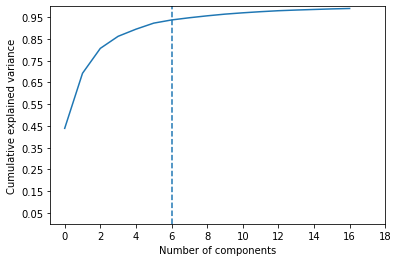

In [28]:
# Compute most of the PC components and look at the scree plot.
pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 20, step=2))
plt.axvline(x=6, linestyle='--')
plt.ylim(0,1)


In [29]:
# Decide to just keep the top 6 PCs. Recompute them
pca = PCA(n_components = 6)
princ_comps = pca.fit_transform(data)
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape


(1046826, 6)

In [30]:
# Z scale the PC’s
pca_mean = data_pca.mean()
pca_sd = data_pca.std()
data_pca = (data_pca - pca_mean) / pca_sd
data_pca.describe()


,PC1,PC2,PC3,PC4,PC5,PC6
count,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06
mean,-3.710641e-16,-1.425937e-15,-2.485480e-16,-6.190284e-17,-2.902700e-15,4.414107e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.585169e-01,-2.280285e+02,-1.990058e+02,-2.023902e+02,-2.438860e+02,-2.002480e+02
25%,-1.088008e-01,-1.544611e-01,-1.356178e-01,-3.269414e-02,-1.159056e-01,-1.101846e-01
50%,-2.375699e-02,-5.919442e-02,6.964951e-04,1.366908e-02,-1.313772e-02,-2.535330e-02
75%,3.290240e-02,3.225958e-02,3.206016e-01,7.018400e-02,4.879487e-02,1.382280e-01
max,6.907817e+02,3.239819e+02,5.967327e+02,2.507935e+02,4.068852e+02,4.017194e+02


### Model 1: Z Score Outliers


In [31]:
p=2
one_over_p = 1/p
score1 = (((data_pca).abs()**p).sum(axis=1))**one_over_p


### Model 2: autoencoder error


In [36]:
from keras.models import Model
from keras.layers import Input, Dense
# placeholder for input
data_in = Input(shape=(6,))
# dimension of the encoded data. Choose 3
encoded_dim = 3
# encoded representation of the data
encoded = Dense(encoded_dim, activation='tanh')(data_in)
# reconstruction of the input
decoded = Dense(6,activation='tanh')(encoded)
# this model maps the input data to the reconstructed data
autoencoder = Model(data_in, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(data_pca,data_pca, epochs=3, shuffle=True, validation_data=(data_pca,data_pca))

pca_out = autoencoder.predict(data_pca)
error = pca_out - data_pca
p=2
oop=1/p
score2 = ((error.abs()**p).sum(axis=1))**oop


Epoch 1/3
32714/32714 [==============================] - 52s 2ms/step - loss: 1.0802 - val_loss: 0.8952ETA: 0s - loss: 1.
Epoch 2/3
32714/32714 [==============================] - 52s 2ms/step - loss: 0.6535 - val_loss: 0.8913
Epoch 3/3
32714/32714 [==============================] - 51s 2ms/step - loss: 1.1160 - val_loss: 0.8911


In [37]:
# Make the final score as the average ranking
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores['final'] = (scores['score1 rank'] + scores['score2 rank'])/2
top_records = scores.sort_values(['final'], ascending = False).head(100).index


In [38]:
top_records

Int64Index([ 898846,  667828, 1042136, 1036415,  148125,   39267,  115122,
              11988,   33294,  648382,  241789,  914593,  317882,  105181,
              33107,   47704,  753749,  735155,  137449,  594392,   94946,
              55582,  232192,  317883,  648381,  102923,  622448,   14878,
             633027,  953143,  105223,  799571,   59907,  803133,  152679,
             799624,  893638,  206300,  107556,     413,  383734,     407,
              85924,   55581,   41418,   47468,    7030,  667687,  970553,
             898849,  973761,  973757,  973755,  973759,   88314,  694913,
             627152,   22981,  973763,    7032,   63702,  565123,  971098,
             898848,  984763,   56413,  115121,   29934,   87359,   73443,
             800347,  499768,  668040,  587330,  906638,  914592,   43737,
              84943,       1,   88313,  563493,  236160,  297298,   89163,
            1039216,    3822,  242437,  314946,  876550,  111951,  954281,
             954279,  954

(0.1, 2088582.7348885664)

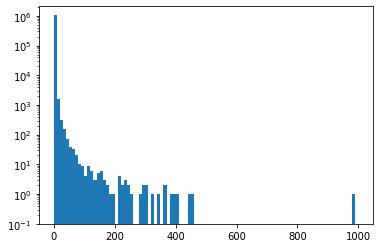

In [67]:
plt.hist(score1, bins=100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

(0.1, 2090081.8681822885)

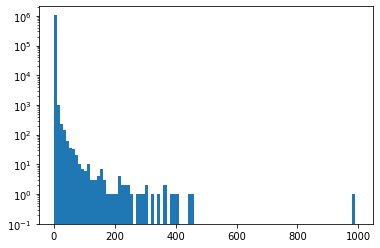

In [68]:
plt.hist(score2, bins=100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

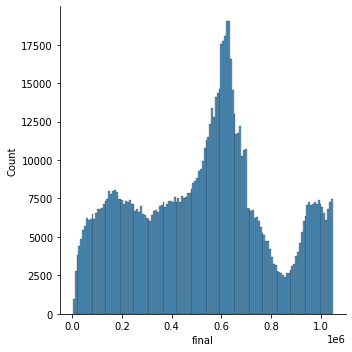

In [69]:
sns.displot(scores['final'])

In [39]:
scores['RECORD']=variables['RECORD']
data['RECORD']=variables['RECORD']

In [46]:
property_data = property_data.merge(scores, on='RECORD')
property_data = property_data.drop(['LOTAREA', 'BLDAREA','BLDVOL', 'score1', 'score2'], axis = 1)

In [51]:
property_data = property_data.merge(data, on ='RECORD')

In [53]:
property_data

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500.000000,...,0.660210,-0.374523,3.352458,2.151291,-0.120245,0.910164,0.790755,-0.110174,0.594662,0.887478
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27.000000,...,7.410371,67.440601,34.383853,22.651090,20.011593,3.221530,2.826725,38.274168,5.752631,8.549314
2,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,82.296384,...,-0.160643,0.030529,0.210577,-0.341588,0.135643,0.087473,-0.048164,0.119092,0.072426,-0.044240
3,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,82.296384,...,-0.153056,0.232287,0.526681,-0.318545,0.266597,0.152378,-0.041856,0.233289,0.124968,-0.035628
4,11,1000041003,1,4,1003,NaN,"TRZ HOLDINGS, LLC",R5,4,82.296384,...,-0.131890,0.795117,1.408496,-0.254265,0.288898,0.163431,-0.040781,0.551860,0.271541,-0.011603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046821,1070990,5080500083,5,8050,83,NaN,"TOBIN, GALE",A1,1,60.000000,...,-0.031258,-0.254092,0.100205,-0.047395,-0.122650,0.000504,-0.016311,-0.116722,-0.002631,-0.020013
1046822,1070991,5080500086,5,8050,86,NaN,SHERRI MILINAZZO,A1,1,62.000000,...,-0.089812,-0.316026,0.198781,0.009474,-0.146820,-0.023026,-0.034721,-0.130674,-0.019812,-0.037437
1046823,1070992,5080500089,5,8050,89,NaN,JOHN GERVASI,A1,1,53.000000,...,0.005444,-0.330737,0.167976,0.087965,-0.140353,0.002467,-0.002886,-0.127275,-0.002609,-0.009092
1046824,1070993,5080500092,5,8050,92,NaN,RITA M MOOG,A1,1,52.000000,...,0.032170,-0.209898,0.363441,0.228920,-0.127395,-0.000132,-0.005427,-0.116604,0.003664,-0.001139
